# Code Calibration

Using examples from Sorensen, J.D. (2004), *Notes in Structural Reliability Theory And Risk Analysis*.

In [1]:
import pystra as pr
import numpy as np
from scipy.optimize import fsolve, minimize
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import gumbel_r

In [2]:
def calibration(reliability_func,Xk,beta_t,output=False,xtol=1e-4,**kwargs):
    """
    Generic reliability calibration function.
    
    Inputs:
    - reliability_func: callable accepting nominal values Xk and returning a Form object
    - Xk: initial values of the nominal variables
    - beta_t: the target reliability index
    - output: diagnostic output
    - kwargs: additional args to be passed to reliability_func
    Return:
    - X_opt: the values of the nominal variables at beta_t
    - form: the form object at the target reliability index
    """
    def obj_func(Xk,beta_t):
        form = reliability_func(Xk,**kwargs)        
        if output:
            print(f"{Xk=} | β = {form.getBeta()} | α = {form.getAlpha()} | x* = {form.getDesignPoint(False)}")
        return beta_t - form.beta
    
    Xk_opt = fsolve(obj_func,x0=Xk,args=(beta_t),xtol=xtol)
    form = reliability_func(Xk_opt,**kwargs)
    return Xk_opt,form

In [3]:
def print_form_results(form):
    print(f"β = {form.getBeta()} | α = {form.getAlpha()} | x* = {form.getDesignPoint(False)}")

In [4]:
def sample_maxima(dist,n,n_sample=1000):
    """
    Sample the distribution of the maximum of n samples from a pystra `dist` object.
    
    Inputs:
    dist: the pystra distribution object from which samples of maxima are sought
    n: the block size from which to take the maximum
    n_samples: the number of samples to produce
    """
    x = dist.sample(n*n_sample).reshape(n,n_sample)
    x_max = np.max(x,axis=0)
    return x_max

In [5]:
def sample_minima(dist,n,n_sample=1000):
    """
    Sample the distribution of the minimum of n samples from a pystra `dist` object.
    
    Inputs:
    dist: the pystra distribution object from which samples of minima are sought
    n: the block size from which to take the minimum
    n_samples: the number of samples to produce
    """
    x = dist.sample(n*n_sample).reshape(n,n_sample)
    x_min = np.min(x,axis=0)
    return x_min

## Partial Factors

### Example 1

Taken from Sorensen (2004), Example 1, pp.141-2

In [6]:
def lsf(z,R,G,Q):
    return z*R - (G + Q)

In [7]:
def reliability(z=10.0,V=0.2):
    ls = pr.LimitState(lsf)
    sm = pr.StochasticModel()
    sm.addVariable(pr.Constant("z", z))
    sm.addVariable(pr.Lognormal("R", 1.0,0.15))
    sm.addVariable(pr.Normal("G", *2*np.array([1, 0.1])))
    sm.addVariable(pr.Gumbel("Q",*3*np.array([1,V])))
    
    form = pr.Form(sm,ls)
    form.run()
    
    return form

In [8]:
df = pd.DataFrame(columns=['β_T', 'V', 'z', 'λ_q', 'r*','g*','q*','γR','γG','γQ'])

for V in [0.2,0.3,0.4]:
    for beta_t in [3.8,4.3,4.8]:
        z, form = calibration(reliability,Xk=15.0,beta_t=beta_t,V=V)
        R,G,Q = form.model.getMarginalDistributions()
        Rk = R.ppf(0.05)
        Gk = G.ppf(0.5)
        Qk = Q.ppf(0.98)
        Xk = np.array([Rk,Gk,Qk])
        Xstar = form.getDesignPoint(False)
        γ = Xstar/Xk

        df.loc[len(df.index)] = [beta_t, V, z[0], Qk/Q.mean,*Xstar,1/γ[0],*γ[1:]]

df.style.format('{:.3f}')

,β_T,V,z,λ_q,r*,g*,q*,γR,γG,γQ
0,3.800,0.200,11.256,1.518,0.702,2.078,5.820,1.103,1.039,1.278
1,4.300,0.200,12.747,1.518,0.675,2.080,6.531,1.145,1.040,1.434
2,4.800,0.200,14.462,1.518,0.649,2.081,7.306,1.192,1.040,1.604
3,3.800,0.300,13.367,1.778,0.740,2.053,7.840,1.046,1.026,1.470
4,4.300,0.300,15.468,1.778,0.712,2.054,8.966,1.086,1.027,1.681
5,4.800,0.300,17.890,1.778,0.684,2.054,10.187,1.131,1.027,1.910
6,3.800,0.400,15.581,2.037,0.761,2.040,9.820,1.017,1.020,1.607
7,4.300,0.400,18.295,2.037,0.733,2.040,11.362,1.056,1.020,1.859
8,4.800,0.400,21.428,2.037,0.703,2.041,13.028,1.100,1.020,2.132


## Load Combinations

### Example 2
Taken from Sorensen (2004), Example 4, pp.190-1. Notes: 

1. The loads described as $Q_1$ and $Q_2$, are not the point-in-time loads, but the annual maxima distributions, from which the point-in-time loads are to be inferred.
2. There is an error in the textbook, and the wind load $Q_2$ is not taken as occurring $r_2 = 360$ times per year as stated, but instead $r_2=2$ per year. 

Only with these adaptations, do the results match.

In [9]:
def lsf(z,R,G,Q1,Q2):
    return z*R - (0.4*G + 0.6*Q1 + 0.3*Q2)

In [10]:
# Point-in-time & annual max distributions
Q1max = pr.Gumbel("Q1",1,0.2)
Q2max = pr.Gumbel("Q2",1,0.4)
# Parameters of inferred parents
Q1pit = pr.Gumbel("Q1",0.89, 0.2)
Q2pit = pr.Gumbel("Q2",0.77, 0.4)
# Using new Parent distribution from pystra (not yet merged)
#Q1pit = pr.Parent("Q1",Q1max,2)
#Q2pit = pr.Parent("Q2",Q2max,2)

In [11]:
def reliability(z=1.0,lc=1):
    ls = pr.LimitState(lsf)
    sm = pr.StochasticModel()
    sm.addVariable(pr.Constant("z", z))
    sm.addVariable(pr.Lognormal("R", 1.0,0.15))
    sm.addVariable(pr.Normal("G", 1, 0.1))
    
    # Choose distribution depending on load case
    if lc == 2:
        sm.addVariable(Q1pit)
        sm.addVariable(Q2max) 
    else:
        sm.addVariable(Q1max)
        sm.addVariable(Q2pit)
    
    form = pr.Form(sm,ls)
    form.run()
    
    return form

In [12]:
lc = 1
Rk_1, form_1 = calibration(reliability,Xk=3.0,beta_t=4.3,lc=lc)
print_form_results(form_1)

β = 4.2999999997675875 | α = [-0.64155965  0.08627279  0.53896114  0.53896114] | x* = [0.65528626 1.03713177 1.62355976 2.01711952]


In [13]:
lc = 2
Rk_2, form_2 = calibration(reliability,Xk=3.0,beta_t=4.3,lc=lc)
print_form_results(form_2)

β = 4.299999999615988 | α = [-0.64216869  0.08625869  0.53859949  0.53859949] | x* = [0.65502999 1.0371257  1.51291126 2.24582252]


In [14]:
Qk = np.array([Q1max.ppf(0.98),Q2max.ppf(0.98)])
Qk

array([1.51845518, 2.03691035])

In [15]:
Q_star = np.array([ form_1.getDesignPoint(False)[-2:], form_2.getDesignPoint(False)[-2:] ]).T
Q_star

array([[1.62355976, 1.51291126],
       [2.01711952, 2.24582252]])

In [16]:
γ = Q_star/Qk[:,None]
γ

array([[1.0692181 , 0.99634898],
       [0.9902839 , 1.10256326]])

In [17]:
ψ = γ/np.diag(γ)
ψ

array([[1.        , 0.90366604],
       [0.92617577, 1.        ]])

### Tuning of Sorensen's parameters

Because of the error in the textbook, quite a bit of exploratory work was needed to find the cause.

In [18]:
def reliability2(z,x):
    ls = pr.LimitState(lsf)
    sm = pr.StochasticModel()
    sm.addVariable(pr.Constant("z", z))
    sm.addVariable(pr.Lognormal("R", 1.0,0.15))
    sm.addVariable(pr.Normal("G", 1, 0.1))
    
    # To find Sorensen's parameters
    Q1max = pr.Gumbel("Q1",1,0.2)
    Q2max = pr.Gumbel("Q2",1,0.4)
    
    # Opt = 0.57917817, 0.42796312
    # 0.89089033, 0.19967346
    #Q1pit = pr.Gumbel("Q1",x[0],x[1])
    #sm.addVariable(Q1pit)
    #sm.addVariable(Q2max)
    
    # Opt = 0.77089986, 0.40104018
    # 0.57917817, 0.42796312
    Q2pit = pr.Gumbel("Q2",x[0],x[1])
    sm.addVariable(Q1max)
    sm.addVariable(Q2pit)    
    
    form = pr.Form(sm,ls)
    form.run()
    
    return form

In [19]:
def obj_func(x):
    z, form = calibration(reliability2,Xk=3.0,beta_t=4.3,output=False,x=x)
    x_star = form.getDesignPoint(False)
    diff = x_star[2:] - np.array([1.62, 2.03]) # np.array([1.51, 2.25])
    
    print(f"{x=} | {x_star=} | {diff=}")
    
    return np.linalg.norm(diff)

x_opt = minimize(obj_func,x0=[0.5,0.4],method='Nelder-Mead',bounds=[(0.1,1.2),(0.1,0.6)])
x_opt

x=array([0.5, 0.4]) | x_star=array([0.66232795, 1.03729168, 1.64100382, 1.78200764]) | diff=array([ 0.02100382, -0.24799236])
x=array([0.525, 0.4  ]) | x_star=array([0.66166597, 1.03727721, 1.63939433, 1.80378866]) | diff=array([ 0.01939433, -0.22621134])
x=array([0.5 , 0.42]) | x_star=array([0.66544148, 1.03626096, 1.54713615, 2.07118623]) | diff=array([-0.07286385,  0.04118623])
x=array([0.525, 0.42 ]) | x_star=array([0.66478769, 1.0362482 , 1.54608407, 2.0918623 ]) | diff=array([-0.07391593,  0.0618623 ])
x=array([0.5 , 0.44]) | x_star=array([0.66930354, 1.03509884, 1.46600765, 2.35300155]) | diff=array([-0.15399235,  0.32300155])
x=array([0.51875, 0.41   ]) | x_star=array([0.66327997, 1.03677549, 1.59243344, 1.94129855]) | diff=array([-0.02756656, -0.08870145])
x=array([0.49375, 0.41   ]) | x_star=array([0.66393778, 1.03678912, 1.5937528 , 1.92008426]) | diff=array([-0.0262472 , -0.10991574])
x=array([0.5171875, 0.4175   ]) | x_star=array([0.66455493, 1.03638747, 1.55744632, 2.0495

 final_simplex: (array([[0.77089986, 0.40104018],
       [0.77080669, 0.40104659],
       [0.7708854 , 0.40103861]]), array([9.01172036e-06, 1.09067063e-05, 2.59459141e-05]))
           fun: 9.011720358810416e-06
       message: 'Optimization terminated successfully.'
          nfev: 84
           nit: 44
        status: 0
       success: True
             x: array([0.77089986, 0.40104018])

μ = 0.9818462589784923, σ = 0.19450298564871332


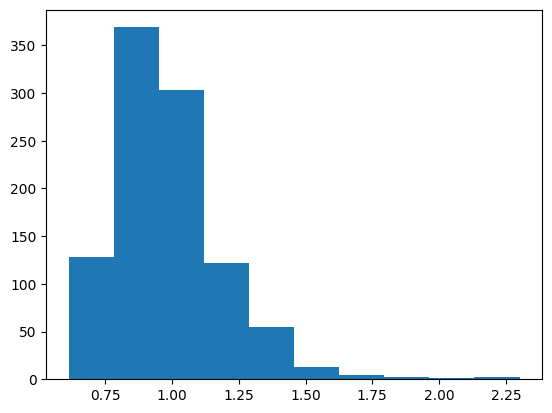

In [20]:
d = pr.Gumbel("Q1",0.89, 0.2)
x_max = sample_maxima(d,2)
l,s = gumbel_r.fit(x_max)
μ,σ2 = gumbel_r.stats(loc=l,scale=s)
print(f"μ = {μ}, σ = {np.sqrt(σ2)}")
plt.hist(x_max);

μ = 0.9841971900069314, σ = 0.3936093842398042


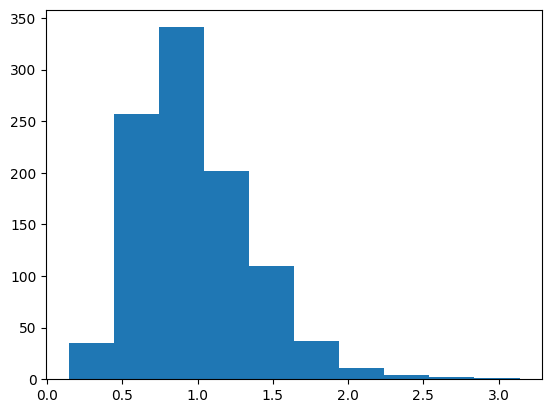

In [21]:
d = pr.Gumbel("Q2",0.77, 0.40)
x_max = sample_maxima(d,2)
l,s = gumbel_r.fit(x_max)
μ,σ2 = gumbel_r.stats(loc=l,scale=s)
print(f"μ = {μ}, σ = {np.sqrt(σ2)}")
plt.hist(x_max);